In [1]:
import sys, os
sys.path.append("lib") # adding "lib" path with own packages
from Sigma_mol import sigma_mol # reads the radio sounsing and compute extinction coefficient
from scipy.interpolate import interp1d # to interpolate modeled variables to lidar heights
from lidar_integrating_space_time import Lidar_space_time as lidar_integ #integrates lidar raw data in height and time
from lidar_integrating_space_time_std import Lidar_space_time2 as lidar_integ_std #maybe not used
from fft_denoising import fft_denoising #maybe not used
from klett import Klett81b #maybe not used
import numpy as np 
import pylab #plots
from DP_simp import DP_simp # Curve simplification
from running_mean import running_mean # runing mean
from time2epoch import time2epoch #maybe not used?
#from cloud_mask_v1 import cloud_mask
from netCDF4 import Dataset 
#from time import sleep
from scipy import stats
from scipy.optimize import curve_fit
from dplots import densplot # make 2D desity plots
from Comb_LidarMRR import Comb_LidarMRR4 as Comb_LidarMRR 
from cloud_mask_v2 import cloud_mask2
from sm_paramTOP import sm_paramTOP
import matplotlib
from copy import copy
from BG_corr import BG_corr
import time

In [2]:
##### output Temporal RESolution
TRES = 10 #min. 

##### output Vertical RESolution
VRES = 6 #bins, 1bin = 3.8m # try only 1,2,3,6 bins

#####Load MRR Data
path_MRR = "I:/PHD/Lidar/Inversion_V2/MRR_Data/"
Ze = np.loadtxt(path_MRR + "Ze_"+str(TRES)+"min.txt")
times_MRR = np.loadtxt(path_MRR + "times_"+str(TRES)+"min.txt")
Height_MRR = np.loadtxt(path_MRR + "Height.txt")

Zem = np.ma.masked_where(Ze == -9999, Ze)

#####Load font format

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
        
pylab.rc('font', **font)      

#####Color Parameters
cmap = pylab.cm.jet
bounds = np.linspace(1,3,4)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
bounds2 = np.linspace(0,12,14)
norm2 = matplotlib.colors.BoundaryNorm(bounds2, cmap.N)

cmap2 = pylab.cm.get_cmap(cmap.name,8)

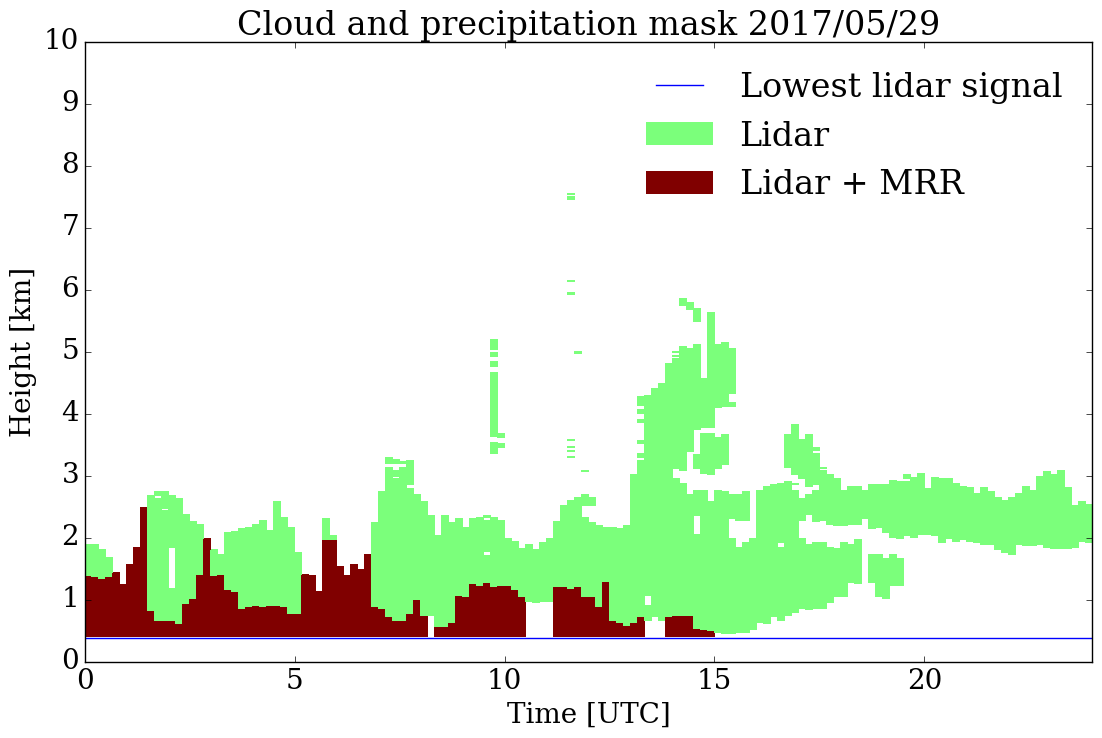

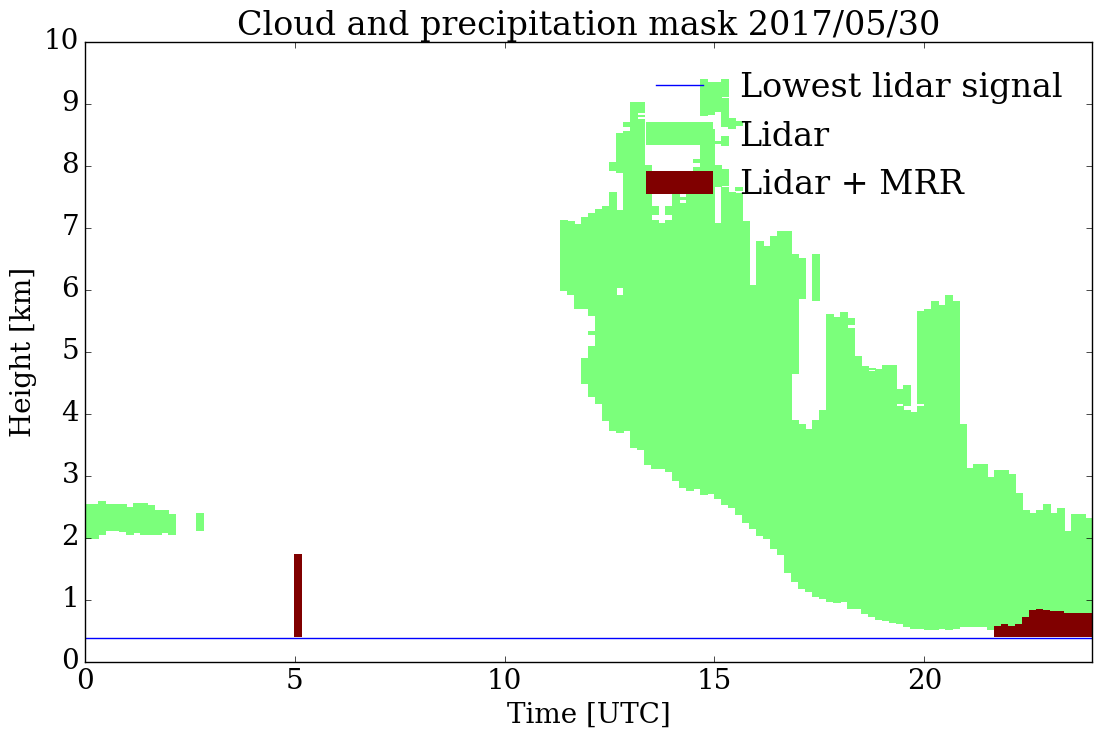

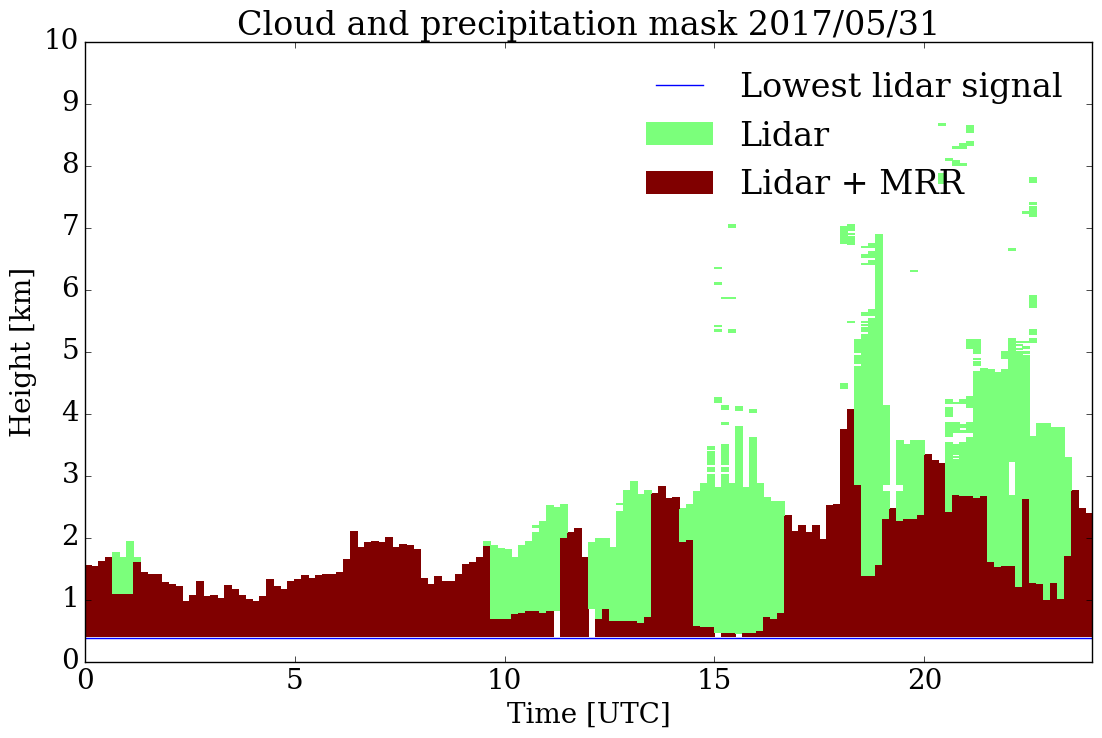

In [7]:
##### Dates 
year0 = [2017,2017]
month0 = [5,5]
day0 = [29,31]

#### Parameters
SNR_threshold = 10 # threshold of SNR (based on Par90 SNR)
nstd = 3 # number of standard deviations in the curve simplification
sm= 5 # window for the temporal moving average
dPlot = False #do plots
check = False # internal code to check step by step the masking algorithm
slr = 0
th = 1.1#4

path_in = "I:/PHD/Lidar/Processing_V3/SysCalibrated/"+str(TRES)+"min"+str(VRES)+"bins/"

r = np.loadtxt("I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/Overlapping_"+str(TRES)+"min_"+str(VRES)+"bins_R.dat")

for year in range(year0[0],year0[1]+1):
    for month in range(month0[0],month0[1]+1):
        for day in range(day0[0],day0[1]+1):

            filename1 = path_in+"Bpar/Bpar_sc_O_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename2 = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/SNR/SNR_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename6 = "C"    
            if os.path.isfile(filename6):
                continue

            if os.path.isfile(filename1):

                Par = np.loadtxt(filename1)[:,int(20.*3./VRES):]
                BASES = np.zeros(shape = (np.size(Par[:,0]),20))
                TOPS = np.zeros(shape = (np.size(Par[:,0]),20))
                Data_mask = np.zeros(shape = np.shape(Par))
                SNR = np.loadtxt(filename2)
                SNR = SNR[:,int(11*3./VRES):][:,int(20.*3./VRES):]

                dbins = np.size(r)-np.size(Par[0,:])
                R = r[dbins:]#_[3:][15:]
                r_ = R#_[3:][15:] # This had sence in previous version of the code =)

                minR = R[1]
                minR_Ze = np.squeeze(np.where(abs(Height_MRR - minR) == min(abs(Height_MRR - minR))))
    
                for h in range(np.shape(Par)[0]):
                    #print h    
                    Y2 = Par[int(h),:]##Y2[15:]
                    
                    AA=running_mean(Y2,sm)#[sm-1:]
                    rr=R[(sm-1)/2:-(sm-1)/2]#pd.rolling_mean(r,sm)[sm-1:]

                    pix=np.squeeze(np.where(AA <0))

                    AAA = np.zeros(shape = np.size(AA)-1)
                    sum = 0
                    for i0 in np.linspace(np.size(AA)-2,0,np.size(AA)-1):
                        i = int(i0)
                        #print i,AA[i],AA[i+1]
                        if ((AA[i]>0) & (AA[i+1]>0)):
                            sum = sum+1
                            #print sum
                            AAA[i]=sum
                        else:
                            sum = 0
                            AAA[i]=sum    

                    AAA[1:] = AAA[1:]-AAA[0:-1]

                    pix2 = np.squeeze(np.where(AAA > 20))

                    if np.size(pix2)>1:

                        deltaH = 0
                        for nlayer in range(np.size(pix2)):
                            #print "nlayer",nlayer

                            rrr = rr[pix2[nlayer]:pix2[nlayer]+int(AAA[pix2[nlayer]])+1]

                            pix3=np.squeeze(np.where((R[:-1] >= rrr[0]) & (R[:-1] <rrr[-1])))#r_[3:-1]

                            Y3 = Y2[pix3[0]-(sm-1)/2:pix3[-1]+(sm-1)/2+2]
                            R3 = R[pix3[0]-(sm-1)/2:pix3[-1]+(sm-1)/2+2]
                            
                            c_mask, baseH, topH, layers, layers_mask = cloud_mask2(Y3,R3,doPlot = dPlot, th = th,nstd=nstd, sm = sm, check = check)

                            #Previous definition of Data Threshold
                            Data_mask[int(h),np.squeeze(np.where(r_ == np.nanmin(R3))):np.squeeze(np.where(r_ == np.nanmax(R3)))+1] = 1.
                            if np.sum(baseH) != -9999:
                                #print baseH,topH
                                BASES[int(h),0+deltaH:np.size(baseH)+deltaH] = baseH
                                TOPS[int(h),0:np.size(topH)+deltaH] = topH
                                deltaH = np.size(baseH)

                    elif np.size(pix2)>=1:

                        rrr = rr[pix2:pix2+int(AAA[pix2])+1]

                        pix3=np.squeeze(np.where((R[:-1] >= rrr[0]) & (R[:-1] <rrr[-1]))) #r_[3:-1]

                        Y3 = Y2[pix3[0]-(sm-1)/2:pix3[-1]+(sm-1)/2+2]
                        R3 = R[pix3[0]-(sm-1)/2:pix3[-1]+(sm-1)/2+2] #r_
                                                
                        #Previous definition of Data Threshold
                        Data_mask[int(h),np.squeeze(np.where(r_ == np.nanmin(R3))):np.squeeze(np.where(r_ == np.nanmax(R3)))+1] = 1.

                        c_mask, baseH, topH, layers, layers_mask = cloud_mask2(Y3,R3,doPlot = dPlot, th = th,nstd=nstd, sm = sm, check = check)

                        if np.sum(baseH) != -9999:
                            BASES[int(h),0:np.size(baseH)] = baseH
                            TOPS[int(h),0:np.size(topH)] = topH            
                 
                #pylab.show()
                #stop
                ###### SNR threshold
                Data_mask = Data_mask*(SNR[:,:]>SNR_threshold)

                ###### Create CLOUD MASK
                TOPSma = np.ma.masked_where(TOPS==0,TOPS) 
                BASESma = np.ma.masked_where(BASES==0,BASES) 

                Cloud_ma = np.zeros(shape = (np.size(Par[:,1]), np.size(r_[:])))
                #Cloud_ma_index = np.zeros(shape = np.shape(Cloud_ma))
                Cloud_ma_indexb = np.zeros(shape = np.shape(Cloud_ma))

                for i in range(np.size(Par[:,1])):
                    for j in range(20):
                        #condition1 = np.bitwise_and(np.uint64(eerr > 0) , np.uint64(nwl < 100))
                        #
                        pix = np.squeeze(np.where(np.uint64(r_[:] >= BASESma[i,j]) & np.uint64(r_[:] <= TOPSma[i,j])))
                        for j2 in pix:
                            Cloud_ma[i,j2] = 1 

                for i in range(np.shape(Cloud_ma)[0]-4):
                    for j in range(np.shape(Cloud_ma)[1]-4):
                        val = np.sum(Cloud_ma[i,j-1:j+2])+np.sum(Cloud_ma[i+1,j-1:j+2])+np.sum(Cloud_ma[i+3,j-1:j+2])+np.sum(Cloud_ma[i+4,j-1:j+2])
                        Cloud_ma_indexb[i+2,j+2] =val*Cloud_ma[i+2,j+2] 
                for j in range(np.shape(Cloud_ma)[1]-2):
                    Cloud_ma_indexb[0,j+2] = Cloud_ma[0,j+2]*(2+np.sum(Cloud_ma[1:3,j-1:j+2]))
                    Cloud_ma_indexb[1,j+2] = Cloud_ma[0,j+2]*(2+np.sum(Cloud_ma[1:4,j-1:j+2]))
                    Cloud_ma_indexb[-1,j+2] = Cloud_ma[-1,j+2]*(2+np.sum(Cloud_ma[-3:-1,j-1:j+2]))    
                    Cloud_ma_indexb[-2,j+2] = Cloud_ma[-2,j+2]*(2+np.sum(Cloud_ma[-4:-2,j-1:j+2]))    

                Cloud_mask2 = Cloud_ma_indexb > 6    

                hours = np.linspace(0,24,np.size(Par[:,1]))

                ###### Filter Data_mask and create layer mask
                Data_index = np.zeros(shape= np.shape(Data_mask))

                for i in range(np.shape(Cloud_ma)[0]-2):
                    for j in range(np.shape(Cloud_ma)[1]-2):
                        val = np.sum(Data_mask[i,j-1:j+2])+np.sum(Data_mask[i+2,j-1:j+2])
                        Data_index[i+1,j+1] =val*Data_mask[i+1,j+1] 
                for j in range(np.shape(Cloud_ma)[1]-2):
                    Data_index[0,j+1] = Data_mask[0,j+1]*(1+np.sum(Data_mask[1,j-1:j+2]))
                    Data_index[-1,j+1] = Data_mask[-1,j+1]*(1+np.sum(Data_mask[-2,j-1:j+2]))   

                layers_mask = (Data_index>3)[:,:]+1*Cloud_mask2  
                layers_mask = np.ma.masked_where(layers_mask==0,layers_mask)  
                
                layers_mask2 = Comb_LidarMRR(layers_mask, Par,R,nstd,sm,times_MRR, Ze, year, month, day, hours, TRES=TRES, VRES=VRES, minR_Ze=minR_Ze)
                layers_mask3 = np.ma.masked_where(layers_mask2 == 1, layers_mask2) 
                cmaps = pylab.cm.get_cmap(cmap.name,3)        
                fig, ax1 = pylab.subplots(figsize=(13,8))
                pylab.pcolor(hours,r_,np.transpose(layers_mask3),vmin=1,vmax=3, cmap=cmaps)
                pylab.bar([-11,-12],[0,0], label = "Lidar", color = cmaps(1),edgecolor = "none")
                pylab.bar([-11,-12],[0,0], label = "Lidar + MRR", color = cmaps(3),edgecolor = "none")
                pylab.plot([0,24],[R[1],R[1]], label = "Lowest lidar signal")
                pylab.axis([0,24,0,10])
                pylab.yticks(np.linspace(0,10,11))
                pylab.xlabel("Time [UTC]")
                pylab.ylabel("Height [km]")
                pylab.title("Cloud and precipitation mask " +str(year)+"/"+str(month).zfill(2)+"/"+str(day).zfill(2))
                pylab.legend(frameon = False)
                pylab.savefig("I:/PHD/Lidar/Processing_V3/Cloud_mask/"+str(TRES)+"min"+str(VRES)+"bins/Plots/MASK_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.png",format="png",bbox_inches = 'tight', dpi=300)
                pylab.show()
                np.savetxt("I:/PHD/Lidar/Processing_V3/Cloud_mask/"+str(TRES)+"min"+str(VRES)+"bins/MASK_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.txt", layers_mask2)
                

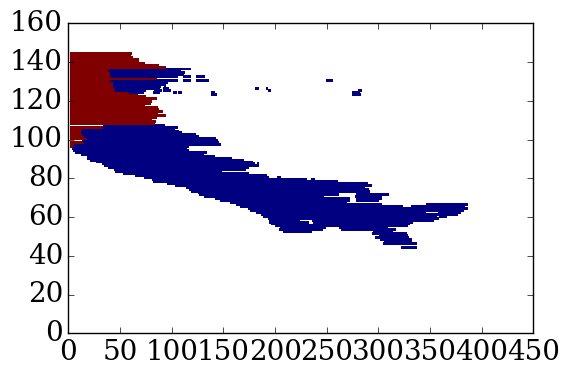

In [6]:
pylab.pcolor(layers_mask3)
pylab.show()

In [5]:
layers_mask2

[array([ 0.3568766 ,  0.37977777,  0.40267894,  0.42558012,  0.44848129,
         0.47138246,  0.49428363,  0.5171848 ,  0.54008598,  0.56298715,
         0.58588832,  0.60878949,  0.63169067,  0.65459184,  0.67749301,
         0.70039418,  0.72329535,  0.74619653,  0.7690977 ,  0.79199887,
         0.81490004,  0.83780122,  0.86070239,  0.88360356,  0.90650473,
         0.9294059 ,  0.95230708,  0.97520825,  0.99810942,  1.02101059,
         1.04391176,  1.06681294,  1.08971411,  1.11261528,  1.13551645,
         1.15841763,  1.1813188 ,  1.20421997,  1.22712114,  1.25002231,
         1.27292349,  1.29582466,  1.31872583,  1.341627  ,  1.36452818,
         1.38742935,  1.41033052,  1.43323169,  1.45613286,  1.47903404,
         1.50193521,  1.52483638,  1.54773755,  1.57063872,  1.5935399 ,
         1.61644107,  1.63934224,  1.66224341,  1.68514459,  1.70804576,
         1.73094693,  1.7538481 ,  1.77674927,  1.79965045,  1.82255162,
         1.84545279,  1.86835396,  1.89125513,  1.9

IndexError: index 0 is out of bounds for axis 0 with size 0

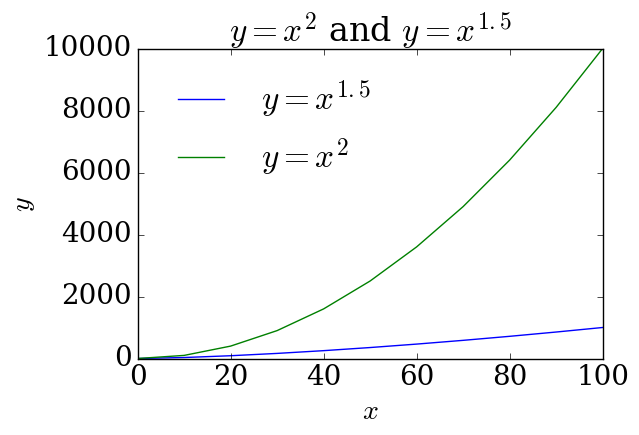

In [395]:
x = np.linspace(0,100,11)
y = x**2
    
pylab.plot(x,x**1.5, label = r'$y = x^{1.5} $')
pylab.plot(x,y, label = r'$y = x^{2} $')
pylab.title(r'$y = x^2 $' + ' and ' + r'$y = x^{1.5} $')
pylab.legend(loc = "upper left", frameon = False)
pylab.xlabel(r'$x$')
pylab.ylabel(r'$y$')
pylab.show()

    

In [444]:
cmaps(1)

(0.4838709677419355, 1.0, 0.48387096774193561, 1.0)

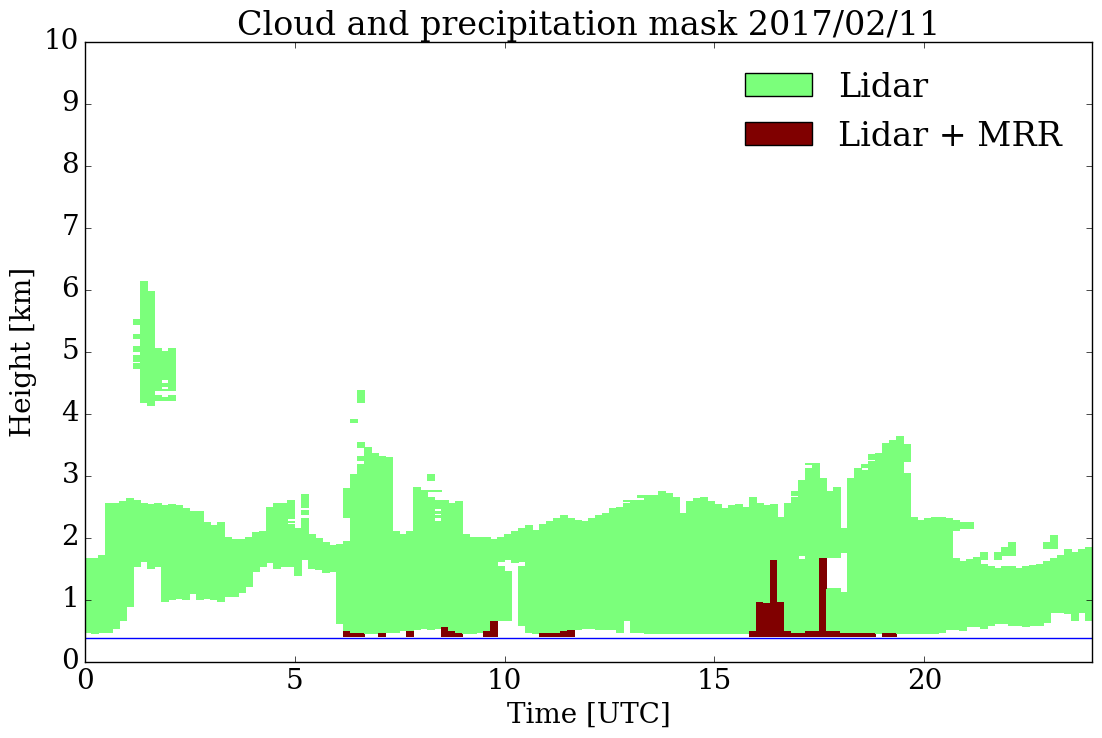

In [450]:
layers_mask3 = np.ma.masked_where(layers_mask2 == 1, layers_mask2) 
cmaps = pylab.cm.get_cmap(cmap.name,3)        
fig, ax1 = pylab.subplots(figsize=(13,8))
pylab.pcolor(hours,r_,np.transpose(layers_mask3),vmin=1,vmax=3, cmap=cmaps)
pylab.bar([-11,-12],[-1,-1], label = "Lidar", color = cmaps(1))
pylab.bar([-11,-12],[-1,-1], label = "Lidar + MRR", color = cmaps(3))
pylab.plot([0,24],[R[1],R[1]])
pylab.axis([0,24,0,10])
pylab.yticks(np.linspace(0,10,11))
pylab.xlabel("Time [UTC]")
pylab.ylabel("Height [km]")
pylab.title("Cloud and precipitation mask " +str(year)+"/"+str(month).zfill(2)+"/"+str(day).zfill(2))
pylab.legend(frameon = False)
pylab.show()


In [352]:
np.unique(layers_mask2)


masked_array(data = [1 2 3 --],
             mask = [False False False  True],
       fill_value = 999999)

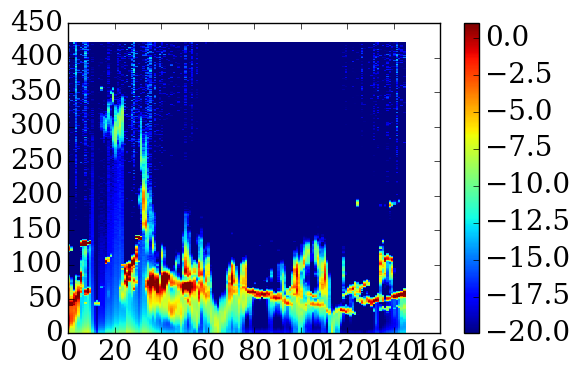

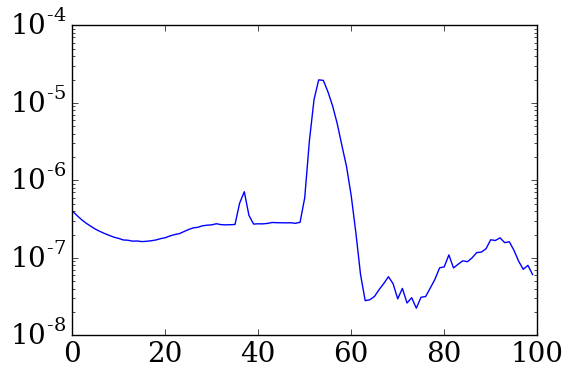

In [402]:
pylab.pcolor(np.transpose(10*np.log10(100000*Par)),vmin =-20,vmax =1) 
pylab.colorbar()
pylab.show()

pylab.plot(Par[140,0:100])
pylab.yscale('log')
pylab.show()

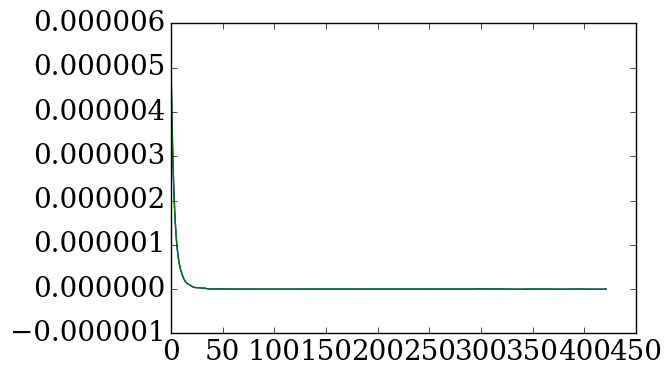

In [501]:
pylab.plot(Par[126,:])
pylab.show()

In [528]:
layers_mask2 = Comb_LidarMRR3(layers_mask, Par,R,nstd,sm,times_MRR, Ze, year, month, day, hours, TRES=TRES, VRES=VRES, minR_Ze=minR_Ze)
pylab.pcolor(np.transpose(layers_mask2))
pylab.show()

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:101: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


ValueError: need more than 1 value to unpack

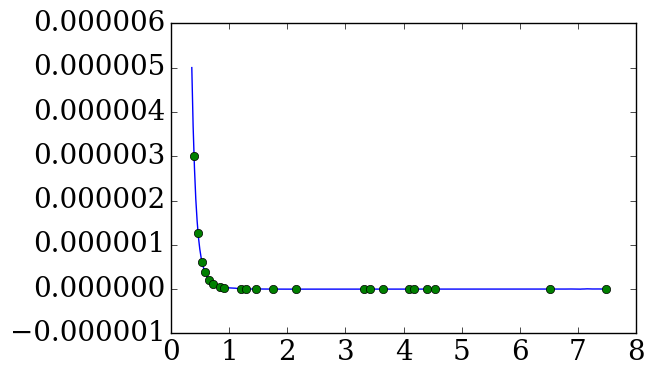

In [525]:
pylab.plot(layers_mask2[0],layers_mask2[1])
pylab.plot(X,Y,"o")
pylab.show()

In [527]:
X,Y,R_,PR2 = DP_simp_test(layers_mask2[0],layers_mask2[1],layers_mask2[2],layers_mask2[3])    

In [504]:
def Comb_LidarMRR3(layers_mask, Par90_bgc, r,nstd,sm,times_MRR, Ze, year, month, day,hours, TRES,VRES,minR_Ze):
    from DP_simp import DP_simp
    import numpy as np
    from copy import copy
    from time2epoch import time2epoch
    import pylab
    #print np.shape(layers_mask), np.shape(Par90_bgc), np.shape(r), np.shape(nstd), np.shape(sm), np.shape(Ze), np.shape(hours)
    layers_mask2 = copy(layers_mask)
    
    for h in range(np.size(hours)):###############################################
    #    try:
    #if 1 == 1:
        
        if int((h)*TRES/60.) < 24:
            time_lidar = time2epoch(year = year, month = month, day = day, hour = int((h)*TRES/60.),minute=int(round(60*((h)*TRES/60. - int((h)*TRES/60.)))))
        elif int((h)*TRES/60.) == 24:
            time_lidar = time2epoch(year = year, month = month, day = day, hour = 0,minute=0)+3600*24
        #print h,time_lidar    
        pix_time = np.squeeze(np.where(time_lidar == times_MRR))
        #print h, pix_time
        pixmask = np.squeeze(np.where(layers_mask[h,:].mask == True))[2]
        #print h,layers_mask[h,15],layers_mask[h,16],layers_mask[h,17],layers_mask[h,18]
        #print h,np.uint64(Ze[pix_time,1] > -18),np.uint64(layers_mask[h,2] == 1)  
        if (np.uint64(Ze[pix_time,minR_Ze] > -18) & np.uint64(layers_mask[h,2] == 1) & np.uint64(np.nansum(layers_mask[h,:])>3)):  
            
        #if ((Ze[pix_time,1] > -18) & (layers_mask[h,16] == 1)):        
            #print "ddd"
            #pylab.plot(Height_MRR,Ze[pix_time,:])
            #pylab.plot(R,Y2)

            #print Height_MRR[1]
            #from DP_simp import DP_simp

            #pixmask = np.squeeze(np.where(layers_mask[h,15:].mask == True))[2]
            if h == 126: 
                return [r[0:pixmask],Par90_bgc[h,:][0:pixmask],nstd,sm]
                    
            X,Y,R_,PR2 = DP_simp(r[0:pixmask],Par90_bgc[h,:][0:pixmask],nstd,sm)    

            #pylab.plot(X,Y,"o")
            #pylab.show()

            slope3 = []
            for i in range(1,np.size(X[:])):
                s3 = (np.log(Y[i]/Y[i-1]))/(X[i]-X[i-1])
                slope3.append(s3)
            #pylab.plot(X[0:-1],slope3,'o-')
            #pylab.axis([0.,7,-1,1])

            base2 = []
            top2 = []

            base2 = X[0]
            Ybase2 = Y[0]

            #print 0, X[0],slope3[i],(slope3[i] <= 0) & (slope3[0] > -0.5)
            for i in range(1,np.size(X)):
                notfound  = False
                #print i
                pix = np.where(r <= X[i])    
                if (2 in layers_mask[h,:][pix]):
                    if np.size(np.squeeze(np.where(layers_mask[h,:][pix] == 2)))>1:
                        top2 = r[pix][np.squeeze(np.where(layers_mask[h,:][pix] == 2))[0]]
                    else:
                        top2 = r[pix][np.squeeze(np.where(layers_mask[h,:][pix] == 2))]
                    #print "break2"
                    break
                notfound  = True           

            #stop    
            count = 0

            if notfound  == True: 
                for i in range(1,np.size(slope3)):
                    #top2 = X[i] 
                    notfound  = False
                    #print i, X[i],slope3[i],(slope3[i] <= 0) & (slope3[i] > -0.5)
                    if ((slope3[i] <= 0) & (slope3[i] > -0.5) & (Y[i]< Ybase2)):
                        top2 = X[i]
                        #print "break1"
                        count = count+1
                        if (count == 2): break
                    else:
                        count = 0
                    notfound  = True

            if notfound  == True:    
                for i in range(i,np.size(X)):
                    notfound  = False
                    #print i
                    pix = np.where(r <= X[i])    
                    if (1 in layers_mask[h,:][pix]):
                        top2 = r[pix][np.squeeze(np.where(layers_mask[h,:][pix] == 1))[-1]]
                        #print "break3"
                        break
                    notfound  = True    

            #print str(int((h)/6.)).zfill(2)+":"+str(int(round(60*((h)/6. - int((h)/6.))))).zfill(2), '; Base =',base2, '. Top =',top2

            pixfin = np.squeeze(np.where((r >= base2) & (r <= top2) & (layers_mask.mask[h,:] != True)))
            layers_mask2[h,:][pixfin] = 3
        #except:
        #    check = h
            #print h
        
    return layers_mask2

((289L, 833L), (289L, 863L), (863L,))

In [36]:
ds = Dataset("I:/PHD/Lidar/Inversion_V2/Cloud_mask/Lidar_BGC_mask_20170208.nc")
par_bgc = ds.variables["par_bgc"][:]

height = ds.variables["height"][:]

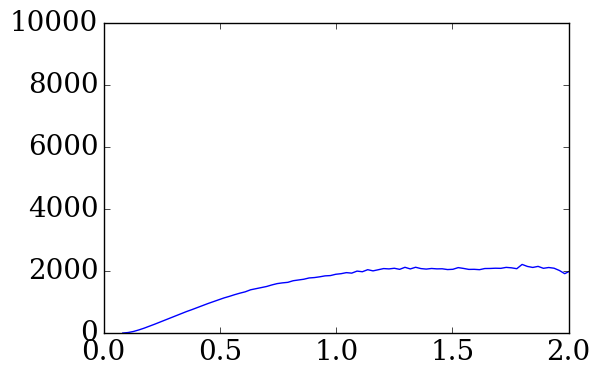

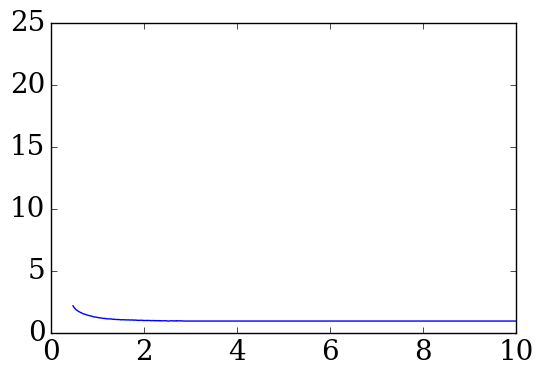

In [113]:
pylab.plot(height,(height**2)*(PAR8[30,3:]-np.mean(PAR8[30,-50:])))
pylab.axis([0,2,0,10000])
pylab.show()

path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"

O = np.loadtxt(path_in + "Overlapping_"+str(TRES)+"min_"+str(VRES)+"bins.dat")

pylab.plot(r_,O[30:])
pylab.axis([0,10,0,25])
pylab.show()

In [93]:
RCOR = np.loadtxt("I:/PHD/Lidar/Processing_V3/Signals/5min3bins/Overlapping_5min_3bins_R_interpolCOR.dat")
OCOR = np.loadtxt("I:/PHD/Lidar/Processing_V3/Signals/5min3bins/Overlapping_5min_3bins_interpolCOR.dat")     
PAR8 = np.loadtxt("I:/PHD/Lidar/Inversion_V2/Signals/Par90/Par90_20170208_10min.dat")

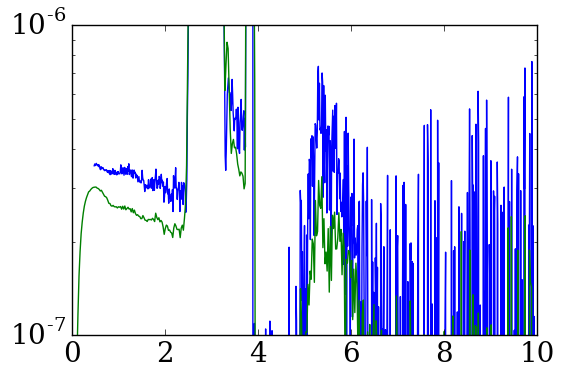

In [114]:
pylab.plot(r_,Par[60,:]*OCOR[30:])
pylab.plot(height,par_bgc[6*5,:]/10000000000)
pylab.plot(PAR8[30,:])
pylab.yscale("log")
pylab.axis([0,10,1e-7,1e-6])
pylab.show()

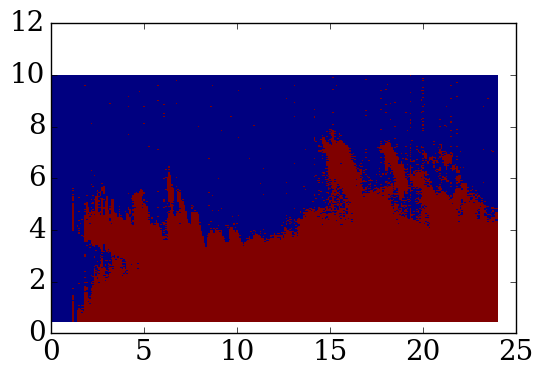

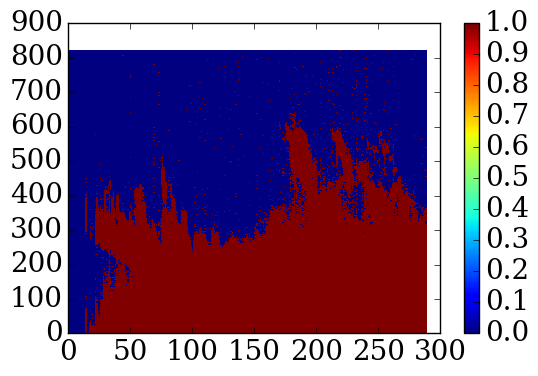

In [69]:
pylab.pcolor(hours,r_,np.transpose(Data_mask))
pylab.show()
pylab.pcolor(np.transpose(SNR[:,11:]>10))
pylab.colorbar()
pylab.show()



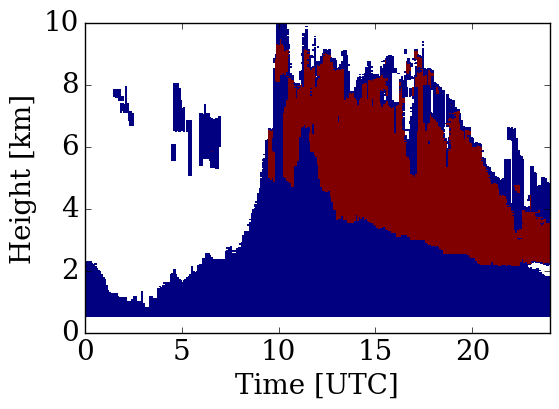

In [3]:
def BG_corr2(P,r,year,month,day, rcf0 = 9, pol = 'parallel',color = "blue"):
    
    import sys, os
    sys.path.append("lib")
    from Sigma_mol import sigma_mol
    from scipy.interpolate import interp1d      
    import time
    from calendar import timegm
    import pylab
    import numpy as np
    from scipy import stats

    utc_time = time.strptime(str(year)+"-"+str(month).zfill(2)+"-"+str(day).zfill(2)+" 00:00:00", "%Y-%m-%d %H:%M:%S")
    epoch_time = timegm(utc_time)  
    
    month2 = time.gmtime(epoch_time+3600*24)[1]
    day2 = time.gmtime(epoch_time+3600*24)[2]
    
    [sigma1, h1] = sigma_mol(year = year, month = month, day = day)
    [sigma2, h2] = sigma_mol(year = year, month = month2, day = day2)
    
    print np.size(sigma1)
    
    if (np.size(sigma1) > 1) & (np.size(sigma2) > 1):
        mat = np.ma.masked_where(np.array([sigma1.filled(-9999),sigma2.filled(-9999)]) == -9999,np.array([sigma1.filled(-9999),sigma2.filled(-9999)]))
        sigma = np.nanmean(mat,axis = 0)[10:]
        h = h1[10:]

    if (np.size(sigma1) == 1) & (np.size(sigma2) > 1):
        sigma = sigma2[10:]
        h = h2[10:]

    if (np.size(sigma1) > 1) & (np.size(sigma2) == 1):
        sigma = sigma1[10:]
        h = h1[10:]
        
    rcf = np.squeeze(np.where(h < rcf0))[-1] 
    rcf_lidar = np.squeeze(np.where(r >= rcf0))[0]
    
    Tm = np.exp((-2*np.cumsum(sigma[rcf:])*(h[1]-h[0])))
    Tm_rcf = np.exp((-2*np.cumsum(sigma[0:rcf])*(h[1]-h[0])))
    Tm_full = np.exp((-2*np.cumsum(sigma)*(h[1]-h[0])))    
    
    if pol == 'parallel':
        beta = 0.996*sigma/((8*np.pi/3)*1.0401)
    if pol == 'perpendicular': 
        beta = 0.00366*sigma/((8*np.pi/3)*1.0401)
        
    f = interp1d(h[rcf:], Tm*beta[rcf:]/(h[rcf:]**2))    
        
    lm = stats.linregress(x = f(r[rcf_lidar:]), y = P[rcf_lidar:])
    
    #pylab.plot(f(r[rcf_lidar:]),P[rcf_lidar:], "o", color = color)
    
    #pylab.plot(np.linspace(np.min(f(r[rcf_lidar:])),np.max(f(r[rcf_lidar:])),3), np.linspace(np.min(f(r[rcf_lidar:])),np.max(f(r[rcf_lidar:])),3)*lm[0]+lm[1], color = color, label = str(year)+"/"+str(month).zfill(2)+"/"+str(day).zfill(2) + " ("+r'$y = $'+str(int(lm[0]))+r'$x$ + ' + str(round(lm[1],2))+", "+r'$r^2 = $'+str(round(lm[2],2))+")")
    
    #print np.mean(P[rcf_lidar:])
    #ax.ticklabel_format(axis = "x", style='scientific',scilimits = (-1,2))
    
    #pylab.legend(frameon = False, loc = "upper left" , fontsize = 18)
    
    return [lm,Tm_full,h,sigma]

In [ ]:
##### output Temporal RESolution
TRES = 10 #min. 

##### output Temporal resolution
VRES = 6 #bins, 1bin = 3.8m # try only 1,2,3,6 bins


for count in range(1000):
    if count > 0: print "Next iteration"
    ##### Dates
    #[ini, end]
    year0 = [2017,2017]
    month0 = [2,12]
    day0 = [1,31]

    ##### Routine
    for year in range(year0[0],year0[1]+1):
        for month in range(month0[0],month0[1]+1):
            for day in range(day0[0],day0[1]+1):

                path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
                filename1 = path_in+"Par90/Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename2 = path_in+"Par10/Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename3 = path_in+"Per/Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename4 = path_in+"Nprofiles/Nprofiles_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min"+".dat"

                path_out = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
                filename5 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename6 = path_in+"Par10_bc/Par10bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename7 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

                filename8 = path_in+"SNR/SNR_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename9 = path_in+"SNR/SNR_Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename10 = path_in+"SNR/SNR_Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

                filename11 = path_in+"Background/BG_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename12 = path_in+"Background/BG_Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename13 = path_in+"Background/BG_Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                
                if os.path.isfile(filename13):
                    #print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data ready"
                    continue
                
                if os.path.isfile(filename1):
                    Par90 = np.loadtxt(filename1)
                    Par10 = np.loadtxt(filename2)
                    Per   = np.loadtxt(filename3)
                    r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
                    npt = np.loadtxt(filename4)

                    BG1 = np.zeros(shape = np.shape(Par90)[0])
                    BG10 = np.zeros(shape = np.shape(Par90)[0])
                    BG2 = np.zeros(shape = np.shape(Par90)[0])

                    print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data loaded"
                else:
                    #print "File not found"
                    continue

                Par_bc = np.zeros(shape = np.shape(Par90))
                Par10_bc = np.zeros(shape = np.shape(Par90))
                Per_bc = np.zeros(shape = np.shape(Per))
                SNR_par = np.zeros(shape = np.shape(Per))
                SNR_par10 = np.zeros(shape = np.shape(Per))
                SNR_per = np.zeros(shape = np.shape(Per))

                for i in range(np.shape(Par90)[0]):
                    try:
                        BG1[i] = BG_corr(Par90[i,:],r[:],year, month, day,rcf0 = 9,pol = 'parallel')[0][1]
                        BG10[i] = BG_corr(Par10[i,:],r[:],year, month, day,rcf0 = 9,pol = 'parallel')[0][1]
                        BG2[i] = BG_corr(Per[i,:],r[:],year, month, day,rcf0 = 9,pol = 'perpendicular')[0][1]  
                    except:
                        continue
                        
                    if BG1[i] < 0: BG1[i] = 0
                    if BG10[i] < 0: BG10[i] = 0
                    if BG2[i] < 0: BG2[i] = 0

                    if BG1[i] > np.nanmean(Par90[i,-50:]): BG1[i] = np.nanmean(Par90[i,-50:])
                    if BG10[i] > np.nanmean(Par10[i,-50:]): BG10[i] = np.nanmean(Par10[i,-50:])
                    if BG2[i] > np.nanmean(Per[i,-50:]): BG2[i] = np.nanmean(Per[i,-50:])

                    Par_bc[i,:] = Par90[i,:]-BG1[i]
                    Par10_bc[i,:] = Par10[i,:]-BG10[i]
                    Per_bc[i,:] = Per[i,:]-BG2[i]  

                    SNR_par[i,:] = (Par_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Par_bc[i,:]+2*(BG1[i]))**0.5
                    SNR_par10[i,:] = (Par10_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Par10_bc[i,:]+2*(BG10[i]))**0.5
                    SNR_per[i,:] = (Per_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Per_bc[i,:]+2*(BG2[i]))**0.5

                    Par_bc[i,:] = (Par_bc[i,:])*r**2
                    Par10_bc[i,:] = (Par10_bc[i,:])*r**2
                    Per_bc[i,:] = (Per_bc[i,:])*r**2  

                np.savetxt(filename5,Par_bc)
                np.savetxt(filename6,Par10_bc)
                np.savetxt(filename7,Per_bc)

                np.savetxt(filename8,SNR_par)
                np.savetxt(filename9,SNR_par10)
                np.savetxt(filename10,SNR_per)

                np.savetxt(filename11,BG1)
                np.savetxt(filename12,BG10)
                np.savetxt(filename13,BG2)
    print "waiting 15 minutes..."
    time.sleep(15*60)
    print "iteration = ", count
    #month00 = month

20170915 Data loaded


C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:88: RuntimeWarning: invalid value encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:87: RuntimeWarning: invalid value encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:89: RuntimeWarning: invalid value encountered in divide


20170916 Data loaded
20170917 Data loaded
waiting 15 minutes...
iteration =  0
Next iteration
20170918 Data loaded
20170919 Data loaded
20170920 Data loaded
20170921 Data loaded
20170922 Data loaded
20170923 Data loaded
20170924 Data loaded
waiting 15 minutes...
iteration =  1
Next iteration
20170925 Data loaded
20170926 Data loaded
20170927 Data loaded
20170928 Data loaded
20170929 Data loaded
20170930 Data loaded
20171001 Data loaded
20171002 Data loaded
waiting 15 minutes...
iteration =  2
Next iteration
20171003 Data loaded
20171004 Data loaded
20171005 Data loaded
20171006 Data loaded
20171007 Data loaded
20171008 Data loaded
20171009 Data loaded
waiting 15 minutes...
iteration =  3
Next iteration
20171010 Data loaded
20171011 Data loaded
20171012 Data loaded
20171013 Data loaded
20171014 Data loaded
20171015 Data loaded
20171016 Data loaded
20171017 Data loaded
waiting 15 minutes...
iteration =  4
Next iteration
20171018 Data loaded
20171019 Data loaded
20171020 Data loaded
20171

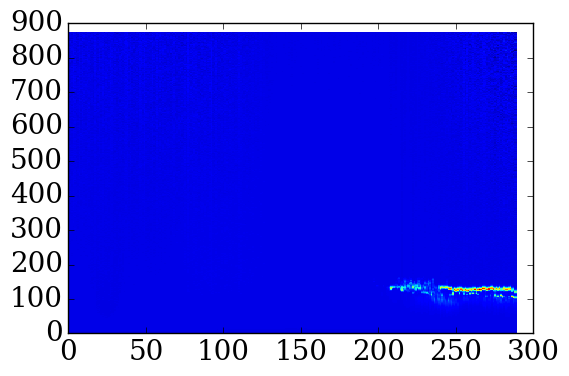

In [216]:
pylab.pcolor(np.transpose(Par10_bc))
pylab.show()

In [197]:
np.shape(npt),np.shape(SNR_par)

((289L,), (289L, 874L))

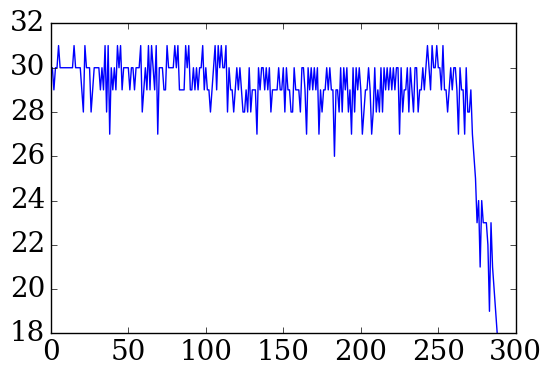

(array([], dtype=int64),)

In [200]:
pylab.plot(npt)
pylab.show()
np.where(npt == 0)

#49487.92592593,   33084.83333333,   24145.90740741,
#         19702.03703704,   18088.27777778,   18037.42592593,
#         18421.7037037 ,   18902.53703704,   19288.85185185,
#         19469.2037037 ,   19583.98148148,   19614.38888889,
#         19550.55555556,   19385.44444444,   19281.74074074,
#         19173.81481481,   190

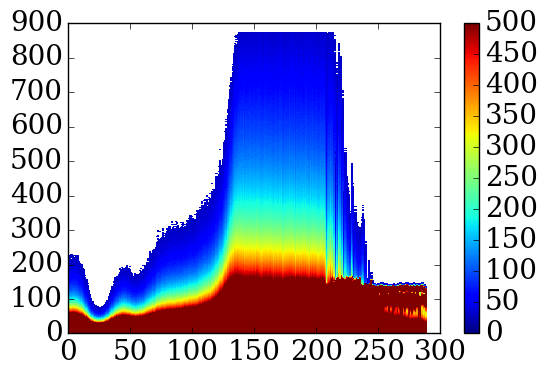

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in log10


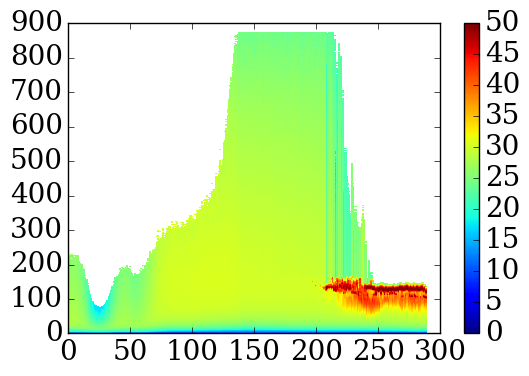

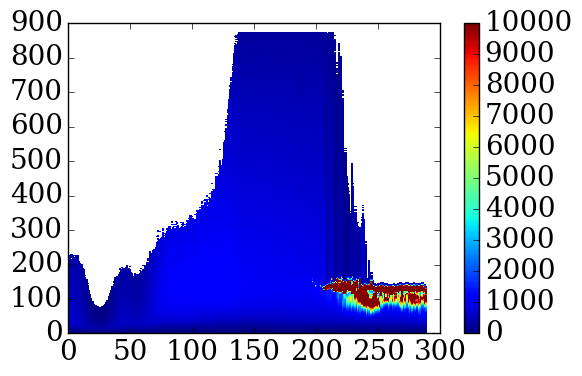

In [201]:
SNR_parb = np.ma.masked_where(SNR_par<30,SNR_par)

pylab.pcolor(np.transpose(SNR_parb), vmin = 0, vmax = 500)
pylab.colorbar()
pylab.show()

SNR_par_2b = np.ma.masked_where(SNR_par_2<30,Par_bc)

pylab.pcolor(np.transpose(10*np.log10(SNR_par_2b)), vmin = 0, vmax = 50)
pylab.colorbar()
pylab.show()

pylab.pcolor(np.transpose(SNR_par_2b), vmin = 0, vmax = 10000)
pylab.colorbar()
pylab.show()

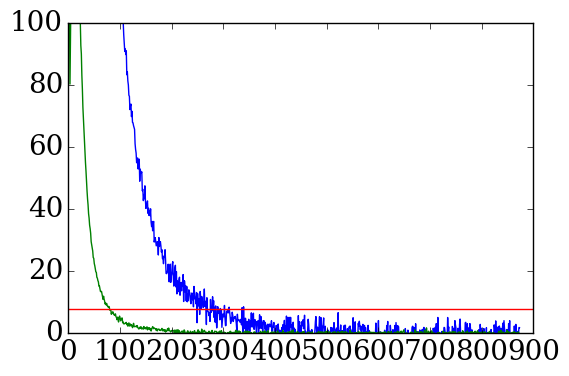

In [206]:

pylab.plot(SNR_par[50,:])
#pylab.plot(SNR_par[150,:])
#pylab.plot(SNR_par[275,:])

pylab.plot(SNR_par10_2[50,:])
#pylab.plot(SNR_per_2[50,:])

pylab.plot([0,900],[8,8])
pylab.axis([0,900,0,100])
pylab.show()

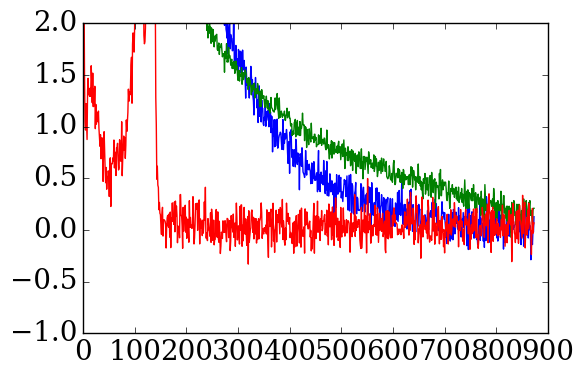

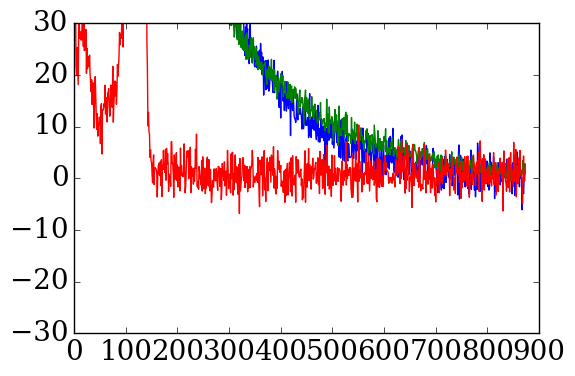

In [189]:
pylab.plot(SNR_par[100,:])
pylab.plot(SNR_par10[150,:])
pylab.plot(SNR_per[275,:])
pylab.axis([0,900,-1,2])
pylab.show()

pylab.plot(SNR_par_2[100,:])
pylab.plot(SNR_par10_2[175,:])
pylab.plot(SNR_per_2[275,:])
pylab.axis([0,900,-30,30])
pylab.show()